
**Install requirements**

In [1]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

**Import libraries**

In [2]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt 
from statistics import mean 

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet, resnet18, resnet50

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [3]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101    # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 32     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05      # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 5

In [4]:
PRE_TRAINED = True     # set to True to load the pre-trained AlexNet

FREEZING = None        # define which layers of the network will be kept frozen
                       # None : train the whole network
                       # "CONV" : train only the FC-layers
                       # "FC" : train only the conv-layers

AUG_PROB = 0.5   # the probability with witch each image is transformed at training time during each epoch
AUG_TYPE = None      # define the type of augmentation pipeline 
                     # None for no data augmentation
                     # "CS-HF" for contrast + saturation + horizontal flip
                     # "H-RP" for hue + random perspective
                     # "B-GS-R" for brightness + grayscale + rotation 

**Define Data Preprocessing and Augmentation**

In [5]:
if PRE_TRAINED:
  normalizer = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
else:
  normalizer = transforms.Normalize(mean = (0.5, 0.5, 0.5), std=(0.229, 0.224, 0.225))

# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor()
])


# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224), 
                                     transforms.ToTensor()                               
])


In [6]:
bright_t = transforms.ColorJitter(brightness=[1,2])
contrast_t = transforms.ColorJitter(contrast = [2,5])
saturation_t = transforms.ColorJitter(saturation = [1,3])
hue_t = transforms.ColorJitter(hue = 0.2)
gs_t = transforms.Grayscale(3)
hflip_t = transforms.RandomHorizontalFlip(p = 1)
rp_t = transforms.RandomPerspective(p = 1, distortion_scale = 0.5)
rot_t = transforms.RandomRotation(degrees = 90)

aug_transformations = {
    "CS-HF": transforms.Compose([contrast_t, saturation_t, hflip_t]),
    "H-RP": transforms.Compose([hue_t, rp_t]),
    "B-GS-R": transforms.Compose([bright_t, gs_t, rot_t])
    }

if AUG_TYPE is not None:
  aug_transformation = aug_transformations[AUG_TYPE]
  aug_pipeline = transforms.Compose([ 
                                      transforms.ToPILImage(),
                                      transforms.RandomApply([aug_transformation], p = AUG_PROB),
                                      transforms.ToTensor(),
                                      normalizer
                                     ])
else:
  aug_pipeline = normalizer


**Prepare Dataset**

In [7]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'
  !git clone https://github.com/frattinfabio/MLDL-hw2-DL.git
  !mv 'MLDL-hw2-DL/caltech_dataset.py' 'Caltech101/caltech_dataset.py' 

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech
from sklearn.model_selection import train_test_split

# Prepare Pytorch train/test Datasets
train_dataset_big = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

indexes = range(0, len(train_dataset_big))
splitting = train_test_split(indexes, train_size = 0.5, random_state = 42, stratify = train_dataset_big.data["label"], shuffle = True)
train_indexes = splitting[0]
val_indexes = splitting[1]

train_dataset = Subset(train_dataset_big, train_indexes)
val_dataset = Subset(train_dataset_big, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [8]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [9]:
def showimage(tensor):
  plt.imshow(tensor.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


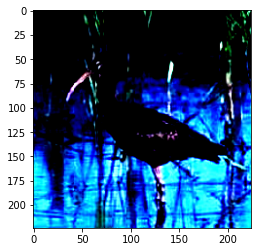

In [10]:
%matplotlib inline
showimage(aug_pipeline(train_dataloader.dataset.__getitem__(4)[0]))

**Prepare Network**

In [11]:
# net = alexnet(pretrained= PRE_TRAINED) # Loading AlexNet model
# net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

net = resnet50(pretrained=PRE_TRAINED)
net.fc = nn.Linear(net.fc.in_features, NUM_CLASSES)

**Prepare Training**

In [12]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# e.g.: parameters of the whole network: net.parameters()
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: net.features.parameters() or net.fc.parameters()
if FREEZING is not None:
  if FREEZING == "FC":
    parameters_to_optimize = net.features.parameters() 
  else:
    # parameters_to_optimize = net.classifier.parameters()
    parameters_to_optimize = net.fc.parameters()
else:
  parameters_to_optimize = net.parameters()

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Validation**

In [13]:
def evaluate(net, dataloader, print_tqdm = True):
  with torch.no_grad():
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode
    running_corrects = 0
    iterable = tqdm(dataloader) if print_tqdm else dataloader
    losses = []
    for images, labels in iterable: 
      norm_images = []
      for image in images:
        norm_image = normalizer(image)
        norm_images.append(norm_image)
      norm_images = torch.stack(norm_images)  
      norm_images = norm_images.to(DEVICE)
      labels = labels.to(DEVICE)
      # Forward Pass
      outputs = net(norm_images)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    # Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))

  return accuracy, mean(losses)

**Train and Validation**

In [14]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0

val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    aug_images = []

    for image in images:
      aug_image = aug_pipeline(image) 
      aug_images.append(aug_image) 

    aug_images = torch.stack(aug_images)

    # Bring data over the device of choice
    aug_images = aug_images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(aug_images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  train_acc, train_loss = evaluate(net, train_dataloader, print_tqdm = False)
  train_accuracies.append(train_acc)
  train_losses.append(train_loss)
  
  val_acc, val_loss = evaluate(net, val_dataloader, print_tqdm = False)
  val_accuracies.append(val_acc)
  val_losses.append(val_loss)

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/30, LR = [0.05]
Step 0, Loss 4.578166484832764
Step 5, Loss 3.995826482772827
Step 10, Loss 3.309581756591797
Step 15, Loss 5.622054100036621
Step 20, Loss 6.405010223388672
Step 25, Loss 4.768737316131592
Step 30, Loss 5.250072479248047
Step 35, Loss 4.769017696380615
Step 40, Loss 4.697263240814209
Step 45, Loss 4.192816734313965
Step 50, Loss 4.335138320922852
Step 55, Loss 4.22960901260376
Step 60, Loss 4.17182731628418
Step 65, Loss 3.9820940494537354
Step 70, Loss 4.053613185882568
Step 75, Loss 4.283588409423828
Step 80, Loss 4.169053077697754
Step 85, Loss 4.073029518127441
Starting epoch 2/30, LR = [0.05]
Step 90, Loss 3.9167561531066895
Step 95, Loss 3.5648300647735596
Step 100, Loss 4.05512809753418
Step 105, Loss 4.002499580383301
Step 110, Loss 3.9897496700286865
Step 115, Loss 4.062751770019531
Step 120, Loss 3.884197950363159
Step 125, Loss 3.75349497795105
Step 130, Loss 4.374307632446289
Step 135, Loss 4.100374698638916
Step 140, Loss 3.974167585372925

Step 1165, Loss 2.425715208053589
Starting epoch 14/30, LR = [0.05]
Step 1170, Loss 1.4646135568618774
Step 1175, Loss 1.489001989364624
Step 1180, Loss 1.945500135421753
Step 1185, Loss 1.069153904914856
Step 1190, Loss 1.1599715948104858
Step 1195, Loss 1.6056647300720215
Step 1200, Loss 0.794392466545105
Step 1205, Loss 2.110522747039795
Step 1210, Loss 1.2245666980743408
Step 1215, Loss 1.7177748680114746
Step 1220, Loss 2.0472989082336426
Step 1225, Loss 1.482536792755127
Step 1230, Loss 1.0875704288482666
Step 1235, Loss 1.821629285812378
Step 1240, Loss 1.7175461053848267
Step 1245, Loss 1.4184650182724
Step 1250, Loss 2.2009971141815186
Step 1255, Loss 1.898235559463501
Starting epoch 15/30, LR = [0.05]
Step 1260, Loss 0.989317774772644
Step 1265, Loss 0.8618841767311096
Step 1270, Loss 1.3532249927520752
Step 1275, Loss 1.3747072219848633
Step 1280, Loss 1.2519793510437012
Step 1285, Loss 1.346702218055725
Step 1290, Loss 1.4832936525344849
Step 1295, Loss 1.6318989992141724
S

Step 2255, Loss 0.060829728841781616
Step 2260, Loss 0.08874061703681946
Step 2265, Loss 0.06823316216468811
Step 2270, Loss 0.012026041746139526
Step 2275, Loss 0.03877267241477966
Step 2280, Loss 0.03863030672073364
Step 2285, Loss 0.049927741289138794
Step 2290, Loss 0.06617516279220581
Step 2295, Loss 0.05527544021606445
Step 2300, Loss 0.012389719486236572
Step 2305, Loss 0.04851672053337097
Step 2310, Loss 0.0698496401309967
Step 2315, Loss 0.030796080827713013
Step 2320, Loss 0.03305351734161377
Step 2325, Loss 0.0225183367729187
Step 2330, Loss 0.03127312660217285
Step 2335, Loss 0.024554967880249023
Starting epoch 27/30, LR = [0.005000000000000001]
Step 2340, Loss 0.03629171848297119
Step 2345, Loss 0.018157899379730225
Step 2350, Loss 0.018834680318832397
Step 2355, Loss 0.029652267694473267
Step 2360, Loss 0.039946794509887695
Step 2365, Loss 0.03181484341621399
Step 2370, Loss 0.008744925260543823
Step 2375, Loss 0.05223092436790466
Step 2380, Loss 0.10316035151481628
Step 

Best accuracies on the validation set:  0.5992392807745505


<AxesSubplot:xlabel='epoch'>

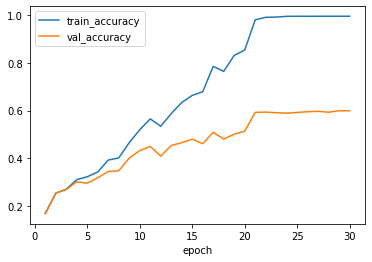

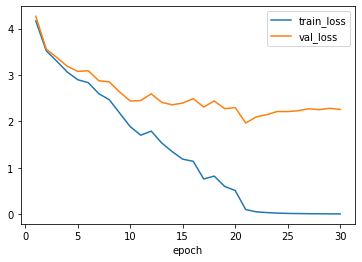

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

print("Best accuracies on the validation set: ", val_acc)

results_df = pd.DataFrame(zip(range(1,NUM_EPOCHS+1), train_accuracies, val_accuracies, train_losses, val_losses), columns = ["epoch", "train_accuracy", "val_accuracy", "train_loss", "val_loss"])
results_df.set_index("epoch")
results_df.plot(x = "epoch", y = ["train_accuracy", "val_accuracy"])
results_df.plot(x = "epoch", y = ["train_loss", "val_loss"])


**Test**

In [16]:
accuracy = evaluate(net, test_dataloader)[0]
print('\nTest Accuracy: {}'.format(accuracy))

100%|██████████| 91/91 [00:17<00:00,  5.25it/s]


Test Accuracy: 0.5948842032492223
